In [1]:
import numpy as np
import numba as nb
from numba import njit, prange
from numpy import ndarray, arange
from derivativeTest import derivativeTest
from loadData import loadData

In [2]:
@njit()
def phi(t: ndarray) -> ndarray:
    l = (t <= 12) * t
    l = np.log(1 + np.exp(l))
    r = l * (t <= 12) + (t > 12) * t
    return r


@njit()
def d_phi(x: ndarray) -> ndarray:
    l = (x <= 12) * x
    l = np.exp(l) / (1 + np.exp(l))
    r = l * (x <= 12) + (x > 12)
    return r
    # if x >= 12:
    #     return 1
    # else:
    #     return np.exp(x) / (1 + np.exp(x))


@njit()
def dd_phi(x: ndarray) -> ndarray:
    cl = (x <= 12) | (x >= -12)
    r = cl * x
    r = (np.exp(r) / np.power((1 + np.exp(r)), 2)) * cl
    return r

Q1(c)

In [3]:
@njit()
def logisticFun(x: ndarray, A: ndarray, b: ndarray):
    n, d = A.shape[0], A.shape[1]
    Ax = A @ x
    v = phi(Ax) - b * Ax
    f = np.sum(v)
    df = np.zeros(d)
    for j in range(d):
        for i in range(n):
            # df[j] += d_phi(A[i] @ x) * A[i, j] - b[i] * A[i, j]
            df[j] += (d_phi(A[i] @ x) * A[i, j] - b[i] * A[i, j])[0]
    hf = np.zeros((d, d))
    dd_phi_Ax = dd_phi(A @ x)
    for i in range(d):
        for j in range(d):
            for k in range(n):
                # hf[i, j] += dd_phi(A[k] @ x) * A[k, i] * A[k, j]
                hf[i, j] += (dd_phi_Ax[k] * A[k, i] * A[k, j])[0]
    return f, df, hf

Q1(d)

In [4]:
n, d = 1000, 50
A = np.random.randn(n, d)
I = np.eye(2, 1)
ind = np.random.randint(2, size=n)
b = I[ind, :]

First Order Error is 3.59e-01;   Second Order Error is 6.10e-02
First Order Error is 9.70e-02;   Second Order Error is 7.86e-03
First Order Error is 2.52e-02;   Second Order Error is 1.06e-03
First Order Error is 6.40e-03;   Second Order Error is 1.60e-04
First Order Error is 1.62e-03;   Second Order Error is 2.04e-05
First Order Error is 4.07e-04;   Second Order Error is 2.53e-06
First Order Error is 1.02e-04;   Second Order Error is 3.13e-07
First Order Error is 2.56e-05;   Second Order Error is 3.72e-08
First Order Error is 6.40e-06;   Second Order Error is 4.92e-09
First Order Error is 1.60e-06;   Second Order Error is 6.17e-10
First Order Error is 4.00e-07;   Second Order Error is 7.76e-11
First Order Error is 1.00e-07;   Second Order Error is 9.82e-12
First Order Error is 2.50e-08;   Second Order Error is 1.26e-12
First Order Error is 6.25e-09;   Second Order Error is 1.65e-13
First Order Error is 1.56e-09;   Second Order Error is 2.24e-14
First Order Error is 3.91e-10;   Second 

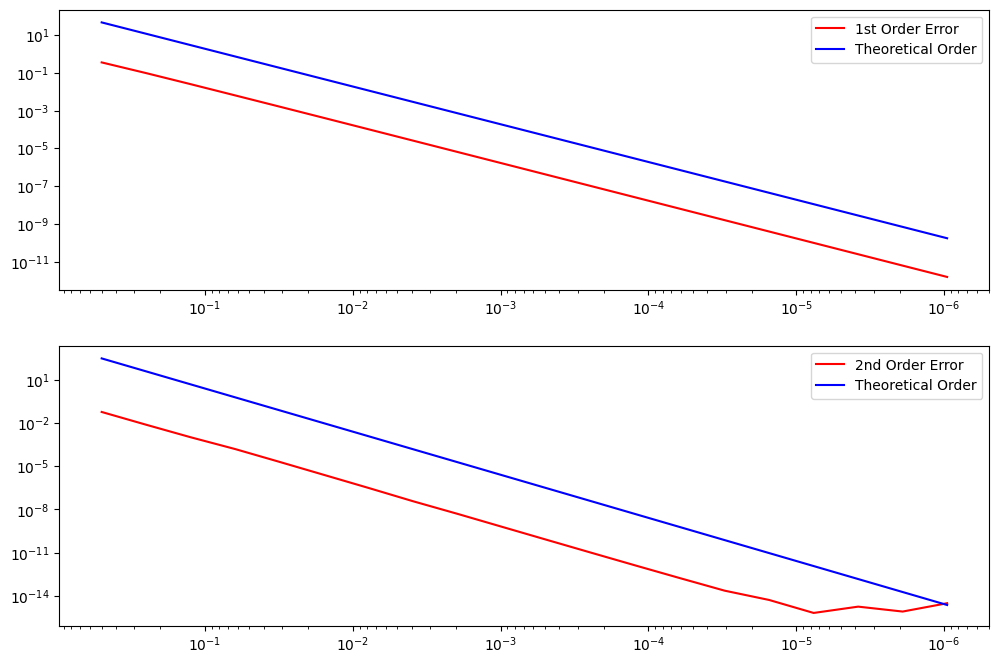

6.55 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [5]:
%%timeit -r 1 -n 1
fun = lambda x: logisticFun(x, A, b)
derivativeTest(fun, np.ones((d, 1)))

Q1(e)

In [6]:
@njit()
def hessian_vector_product(x: ndarray, A: ndarray, b: ndarray, v: ndarray):
    n, d = A.shape[0], A.shape[1]
    eps = 1e-5
    dfp = np.zeros(d)
    dfm = np.zeros(d)
    tp = x + eps * v
    tm = x - eps * v
    # O(nd) time complexity
    for j in range(d):
        for i in range(n):
            dfp[j] += (d_phi(A[i] @ tp) * A[i, j] - b[i] * A[i, j])[0]
            dfm[j] += (d_phi(A[i] @ tm) * A[i, j] - b[i] * A[i, j])[0]
    hv = 1 / (2 * eps) * (dfp - dfm)
    return hv


def hvp_wrapper(x: ndarray, A: ndarray, b: ndarray):
    n, d = A.shape[0], A.shape[1]
    Ax = A @ x
    v = phi(Ax) - b * Ax
    f = np.sum(v)
    df = np.zeros(d)
    for j in range(d):
        for i in range(n):
            df[j] += (d_phi(A[i] @ x) * A[i, j] - b[i] * A[i, j])[0]
    return f, df, lambda v: hessian_vector_product(x, A, b, v)

Q1(f)

First Order Error is 2.70e-01;   Second Order Error is 3.33e-02
First Order Error is 7.48e-02;   Second Order Error is 1.02e-03
First Order Error is 1.92e-02;   Second Order Error is 2.59e-04
First Order Error is 4.81e-03;   Second Order Error is 7.41e-05
First Order Error is 1.20e-03;   Second Order Error is 1.12e-05
First Order Error is 2.98e-04;   Second Order Error is 1.49e-06
First Order Error is 7.42e-05;   Second Order Error is 1.86e-07
First Order Error is 1.85e-05;   Second Order Error is 2.19e-08
First Order Error is 4.63e-06;   Second Order Error is 3.01e-09
First Order Error is 1.16e-06;   Second Order Error is 3.77e-10
First Order Error is 2.89e-07;   Second Order Error is 4.72e-11
First Order Error is 7.23e-08;   Second Order Error is 5.90e-12
First Order Error is 1.81e-08;   Second Order Error is 7.37e-13
First Order Error is 4.52e-09;   Second Order Error is 9.19e-14
First Order Error is 1.13e-09;   Second Order Error is 1.12e-14
First Order Error is 2.82e-10;   Second 

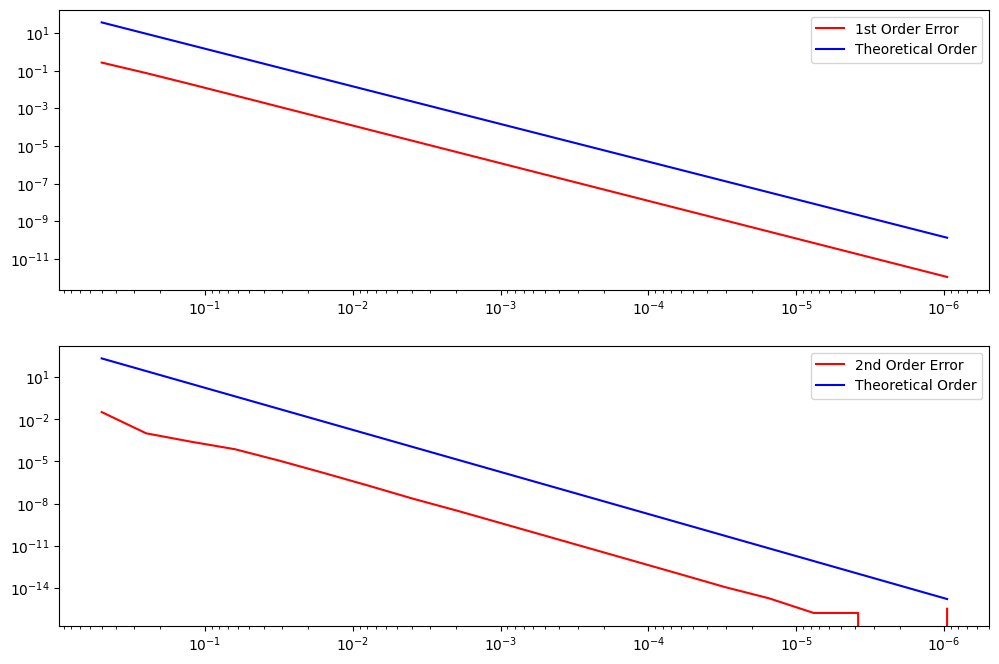

13.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [7]:
%%timeit -r 1 -n 1
fun = lambda x: hvp_wrapper(x, A, b)
derivativeTest(fun, np.ones((d, 1)))

2(c)

In [8]:
@njit()
def logisticFunl2(x: ndarray, A: ndarray, b: ndarray, c: float = 1.0):
    x, b = x.reshape(-1, 1), b.reshape(-1, 1)
    n, d = A.shape[0], A.shape[1]
    Ax = A @ x
    v = phi(Ax) - b * Ax
    f = np.sum(v)
    f = f + c / 2 * np.linalg.norm(x, 2) ** 2
    df = np.zeros(d)
    df = df.reshape(-1, 1)
    d_phi_Ax = d_phi(A @ x)
    for j in range(d):
        for i in range(n):
            df[j] += (d_phi_Ax[i] * A[i, j] - b[i] * A[i, j])[0]
    df = df + c * x
    hf = np.zeros((d, d))
    dd_phi_Ax = dd_phi(A @ x)
    for i in range(d):
        for j in range(d):
            for k in range(n):
                hf[i, j] += (dd_phi_Ax[k] * A[k, i] * A[k, j])[0]
    hf = hf + np.eye(d) * c
    return f, df, hf

First Order Error is 3.75e-01;   Second Order Error is 7.00e-02
First Order Error is 1.04e-01;   Second Order Error is 7.42e-03
First Order Error is 2.73e-02;   Second Order Error is 4.81e-04
First Order Error is 6.96e-03;   Second Order Error is 1.14e-05
First Order Error is 1.74e-03;   Second Order Error is 8.17e-06
First Order Error is 4.36e-04;   Second Order Error is 1.51e-06
First Order Error is 1.09e-04;   Second Order Error is 2.18e-07
First Order Error is 2.72e-05;   Second Order Error is 2.94e-08
First Order Error is 6.79e-06;   Second Order Error is 3.79e-09
First Order Error is 1.70e-06;   Second Order Error is 4.80e-10
First Order Error is 4.24e-07;   Second Order Error is 6.01e-11
First Order Error is 1.06e-07;   Second Order Error is 7.43e-12
First Order Error is 2.65e-08;   Second Order Error is 9.05e-13
First Order Error is 6.62e-09;   Second Order Error is 1.07e-13
First Order Error is 1.66e-09;   Second Order Error is 1.22e-14
First Order Error is 4.14e-10;   Second 

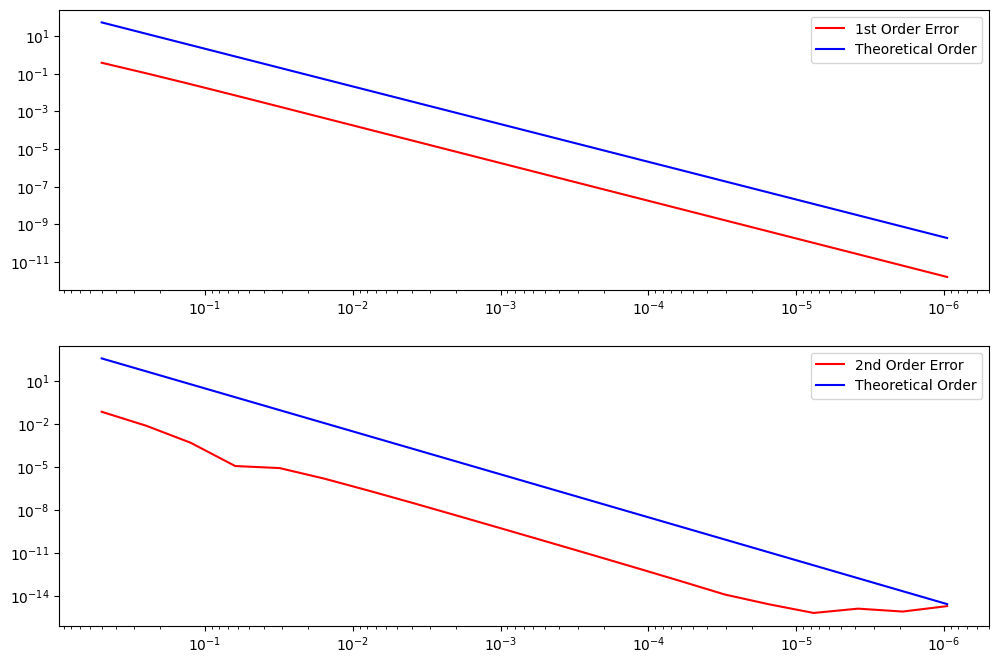

In [9]:
fun = lambda x: logisticFunl2(x, A, b)
derivativeTest(fun, np.ones((d, 1)))

2(d)

In [10]:
@njit()
def gradient_descent(A: ndarray, b: ndarray, c: float = 1.0):
    n, d = A.shape[0], A.shape[1]
    x = np.zeros(d)
    x, b = x.reshape(-1, 1), b.reshape(-1, 1)
    k, cond = 0, 1
    lr = 10 / (1 / 4 * np.linalg.norm(A) ** 2 + c)
    while cond:
        k += 1
        df = np.zeros(d)
        df = df.reshape(-1, 1)
        d_phi_Ax = d_phi(A @ x)
        for j in range(d):
            for i in range(n):
                df[j] += (d_phi_Ax[i] * A[i, j] - b[i] * A[i, j])[0]
        df = df + c * x
        lr = 0.9 * lr
        x = x - lr * df
        tc = np.linalg.norm(df)
        cond = (tc >= 1e-4) & (k < 1000)
    return x


@njit()
def newton_CG(A: ndarray, b: ndarray, c: float = 1.0):
    n, d = A.shape[0], A.shape[1]
    x = np.zeros(d)
    x = x.reshape(-1, 1)
    b = b.reshape(-1, 1)
    k, cond = 0, 1
    while cond:
        _, df, hf = logisticFunl2(x, A, b, c)
        x = x - np.linalg.inv(hf) @ df
        cond = (np.linalg.norm(df) >= 1e-6) & (k < 1000)
        k += 1
    return x

2(e)

In [11]:
def sigmoid(A, x):
    return 1 / (1 + np.exp(-(A @ x)))

2(f)

In [12]:
A_train, b_train, A_test, b_test = loadData()
x = newton_CG(A_train, b_train)
y_proba = sigmoid(A_test, x)
y_hat = y_proba.round()
y_hat = y_hat.reshape(-1,)
print("accuracy = %f" % (y_hat == b_test[:,0]).mean())

accuracy = 0.906623


In [13]:
from sklearn.metrics import roc_auc_score
roc_auc_score(b_test[:,0], y_proba)

0.9621130264970905

In [14]:
@njit
def evalf(x: ndarray, A: ndarray, b: ndarray, c: float = 1.0):
    x, b = x.reshape(-1, 1), b.reshape(-1, 1)
    n, d = A.shape[0], A.shape[1]
    Ax = A @ x
    v = phi(Ax) - b * Ax
    f = np.sum(v)
    f = f + c / 2 * np.linalg.norm(x, 2) ** 2
    return f

In [15]:
n1 = []
fval1 = []
n2 = []
fval2 = []
n3 = []
fval3 = []

def gradient_descent(A: ndarray, b: ndarray, c: float = 1.0):
    n, d = A.shape[0], A.shape[1]
    x = np.zeros(d)
    x, b = x.reshape(-1, 1), b.reshape(-1, 1)
    k, cond = 0, 1
    lr = 10 / (1 / 4 * np.linalg.norm(A) ** 2 + c)
    while cond:
        k += 1
        df = np.zeros(d)
        df = df.reshape(-1, 1)
        d_phi_Ax = d_phi(A @ x)
        for j in range(d):
            for i in range(n):
                df[j] += (d_phi_Ax[i] * A[i, j] - b[i] * A[i, j])[0]
        df = df + c * x
        lr = 0.9 * lr
        x = x - lr * df
        tc = np.linalg.norm(df)
        fval3.append(evalf(x, A, b))
        n3.append(tc)
        cond = (tc >= 1e-4) & (k < 15)
    return x



def newton_CG(A: ndarray, b: ndarray, c: float = 1.0):
    n, d = A.shape[0], A.shape[1]
    x = np.zeros(d)
    x = x.reshape(-1, 1)
    b = b.reshape(-1, 1)
    k, cond = 0, 1
    while cond:
        _, df, hf = logisticFunl2(x, A, b, c)
        nm = np.linalg.norm(df)
        x = x - np.linalg.inv(hf) @ df
        cond = (nm >= 1e-6) & (k < 1000)
        k += 1
        fval1.append(evalf(x, A, b))
        n1.append(nm)
    return x

In [16]:
A_train, b_train, A_test, b_test = loadData()
x = newton_CG(A_train, b_train)
y_proba = sigmoid(A_test, x)
y_hat = y_proba.round()
y_hat = y_hat.reshape(-1,)
print("accuracy = %f" % (y_hat == b_test[:,0]).mean())

accuracy = 0.921824


Q4

In [17]:
def agd(A: ndarray, b: ndarray, c: float = 1.0):
    k = 4
    a = (np.sqrt(k) - 1) / (np.sqrt(k) + 1)
    n, d = A.shape[0], A.shape[1]
    x = np.zeros(d)
    lg = 1 / 4 * np.linalg.norm(A) ** 2 + c
    x, b = x.reshape(-1, 1), b.reshape(-1, 1)
    x_last = x
    for m in range(1000):
        y = x + a * (x - x_last)
        x_last = x
        df = np.zeros(d)
        df = df.reshape(-1, 1)
        d_phi_Ax = d_phi(A @ x)
        for j in range(d):
            for i in range(n):
                df[j] += (d_phi_Ax[i] * A[i, j] - b[i] * A[i, j])[0]
        df = df + c * y
        x = y - df / lg
        tc = np.linalg.norm(df)
        fval3.append(evalf(x, A, b))
        n3.append(tc)
        if (tc <= 1e-4) & (m < 15):
            break
    return x


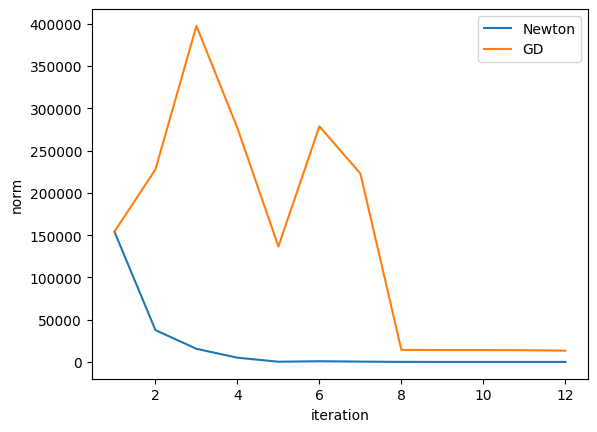

In [19]:
from matplotlib import pyplot as plt
gradient_descent(A_train, b_train)
#agd(A_train, b_train)
x = arange(1, len(n1) + 1, 1)
n3 = n3[0:len(n1)]
#n3 = n3[0:len(n1)]
plt.plot(x, n1, label = "Newton")
plt.plot(x, n3, label = "GD")
#plt.plot(x, n3, label = "AGD")
plt.xlabel("iteration")
plt.ylabel("norm")
plt.legend()
plt.show()

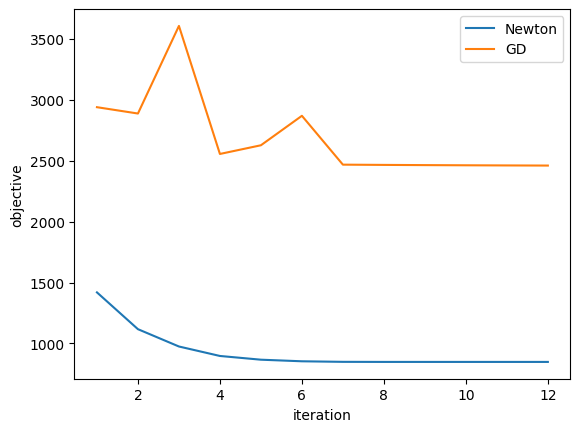

In [21]:
#fval2 = fval2[0:len(n1)]
fval3 = fval3[0:len(n1)]
plt.plot(x, fval1, label = "Newton")
plt.plot(x, fval3, label = "GD")
#plt.plot(x, fval3, label = "AGD")
plt.xlabel("iteration")
plt.ylabel("objective")
plt.legend()
plt.show()